In [2]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


# Time of Emergence Plots
 1. loads regional timeseries data from zarr file generated in S2
 2. computes retrospective trends 
 3. generates regional timeseries data


### 1. Load regionalized timeseries data

In [6]:
ds_djf_regional = xr.open_zarr('data/cesm-le-djf-triregion-timeseries-trans.zarr')
ds_djf_regional

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, region: 3, time: 180)
Coordinates:
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * region     (region) <U17 'Southern Ocean' ... 'Atlantic Quadrant'
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Data variables:
    Chl_surf   (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    IFRAC      (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    KGP        (time, length, member_id, region) float64 dask.array<chunksize=(90, 3, 34, 3), meta=np.ndarray>
    SST        (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>
    SST_orig   (time, member_id, region) float64 dask.array<chunksize=(180, 34, 3), meta=np.ndarray>

## 2. compute retrospective trends 

In [7]:
%%time
# set up trend dimensions
trend_year = xr.DataArray(np.arange(1925, 2101, 1), dims=('time'))
trend_length = xr.DataArray([5, 10, 20, 60], dims=('trend_length'))

# loop over trends
ds_list = []
for end_year, n_year in product(trend_year.values, trend_length.values):

    # subset data for the time-period of this trend
    ds = ds_djf_regional.sel(time=slice(end_year-n_year+1, end_year))
    if len(ds.time) != n_year: 
        continue
        
    # loop over vars and compute trends
    da_list = []
    for v in ds.data_vars:
        da = util.linear_trend(
            ds[v]
        ).expand_dims(
            trend_length=[n_year], 
            trend_year=[end_year]
        ) * 10.
        da.attrs = ds[v].attrs
        da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
        da_list.append(da)
        
    ds_list.append(xr.merge(da_list))
    
ds_djf_rgn_trnd = xr.combine_by_coords(ds_list).compute()
ds_djf_rgn_trnd

CPU times: user 1min 26s, sys: 7.34 s, total: 1min 33s
Wall time: 1min 36s


<xarray.Dataset>
Dimensions:       (length: 3, member_id: 34, region: 3, trend_length: 4, trend_year: 176)
Coordinates:
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * region        (region) <U17 'Southern Ocean' ... 'Atlantic Quadrant'
  * length        (length) float64 20.0 40.0 60.0
  * trend_length  (trend_length) int64 5 10 20 60
  * trend_year    (trend_year) int64 1925 1926 1927 1928 ... 2097 2098 2099 2100
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, region) float64 0.01585 ... -0.00122
    IFRAC         (trend_length, trend_year, member_id, region) float64 0.001716 ... -0.002642
    KGP           (trend_length, trend_year, length, member_id, region) float64 -0.001933 ... -0.0002427
    SST           (trend_length, trend_year, member_id, region) float64 0.0917 ... 0.05968
    SST_orig      (trend_length, trend_year, member_id, region) float64 0.188 ... 0.0848

## 3. plot retrospective trends and ToE

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


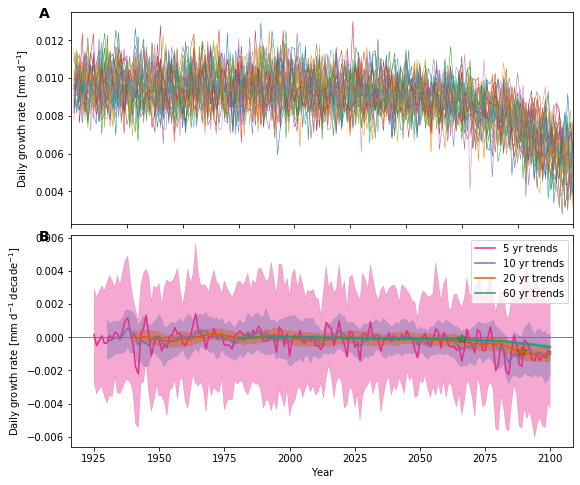

In [8]:
v = 'KGP'
region = 'WAP & Atlantic'

hexcolor = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ax.plot(ds_djf_regional.time, var_i, '-', linewidth=0.5)
    
ax.plot(ds_djf_regional.time, ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id'), '-', 
        linewidth=1, color='k')

ax.set_xticklabels([])
ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]')

ax = fig.add_subplot(gs[1, 0])
handles = []
for n_year in ds_djf_rgn_trnd.trend_length.values:
    da = ds_djf_rgn_trnd[v].sel(trend_length=n_year, region=region, length = 40.)
    
    y_mean = da.mean('member_id')
    y_std = da.std('member_id')
    
    y_low = y_mean - y_std
    y_hi = y_mean + y_std
    
    color = hexcolor.pop()
    
    p = ax.plot(
        ds_djf_rgn_trnd.trend_year, y_mean, 
        '-', label=f'{n_year:d} yr trends', color=color
    )
    handles.append(p[0])
    
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_low,
        '-', label='%d yr trends', color=color,
        linewidth=0.2
    )            
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_hi, 
        '-', label='%d yr trends', color=color, 
        linewidth=0.2
    )
    
    ax.fill_between(
        ds_djf_rgn_trnd.trend_year, y_low, y_hi,
        facecolor=color, alpha=0.4
    )
    

    s2n = y_mean / y_std
    for l in range(len(ds_djf_rgn_trnd.trend_year)):
        
        # where the signal to noise is greater than 2, detect!
        if all(np.abs(s2n[l:]) > 2):
            toex = ds_djf_rgn_trnd.trend_year.values[l]
            toey = y_mean.values[l]
            ax.plot(toex, toey, '*', 
                    color=color, 
                    markeredgecolor='k',
                    markeredgewidth=0.2,
                    markersize=10)
            break
            
ax.legend(handles, [h.get_label() for h in handles])
ax.axhline(0, color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel('Year')
ax.set_ylabel(f'{ds_djf_rgn_trnd[v].long_name} [{ds_djf_rgn_trnd[v].units}]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1 - 0.01
    x = p.x0 - 0.05
    fig.text(x, y, '%s'%alp[i],
             fontsize=14.,
             fontweight='semibold')